# BidMPH v2 Monitor <br> Recife

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import os
# Add the monitor directory to Python path
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import pprint
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.download import download_bid_data_1, download_bid_data
from src.calculations import share_bidding_algorithm, share_bid_price_matches, share_available_prices_length, share_bid_price_matches_by_len

## Parameters

In [24]:
CITY_ID = 4373
CITY_NAME = 'Recife'
ORDER_TYPE = 'moto_econom'

In [4]:
DATA_ROOT_PATH = pathlib.Path(f'data/city_id={CITY_ID}')
if not DATA_ROOT_PATH.exists():
    DATA_ROOT_PATH.mkdir(parents=True, exist_ok=True)

## Downlaoad

total

In [5]:
start_date = '2025-02-28'
end_date = '2025-06-20'

df_total = download_bid_data_1(start_date, end_date, CITY_ID, printBool=False)
df_total.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_total_bids.csv', index=False)
print(f'df_total saved as {CITY_NAME}_total_bids.csv')

df_total saved as Recife_total_bids.csv


df0 ('Before')

In [6]:
start_date = '2025-02-28'
end_date = '2025-03-28'

df0 = download_bid_data(start_date, end_date, CITY_ID, printBool=False)
df0.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_before_bids.csv', index=False)
print(
    'From', df0['utc_bid_dttm'].min(), 
    '\n to', df0['utc_bid_dttm'].max()
)
print(f'df0 saved as {CITY_NAME}_before_bids.csv')

From 2025-02-28 00:00:08+00:00 
 to 2025-03-28 23:59:59+00:00
df0 saved as Recife_before_bids.csv


df1 ('Test')

In [7]:
start_date = '2025-05-05'
end_date = '2025-06-20'

df1 = download_bid_data(start_date, end_date, CITY_ID, printBool=False)
df1.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv', index=False)
print(
    'From', df1['utc_bid_dttm'].min(), 
    '\n to', df1['utc_bid_dttm'].max()
)
print(f'df1 saved as {CITY_NAME}_test_bids.csv')

From 2025-05-05 00:00:08+00:00 
 to 2025-05-26 07:42:52+00:00
df1 saved as Recife_test_bids.csv


## Process Data

In [25]:
def parse_prices(s):
    if isinstance(s, str) and s.startswith('[') and s.endswith(']'):
        items = s.strip('[]').split()
        return [float(item) for item in items] if items and items[0] != '' else []
    else:
        return []  # для None или некорректных значений

total

In [26]:
df_total = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_total_bids.csv')

df_total = df_total[df_total['order_type'] == ORDER_TYPE]
df_total['bidding_algorithm_name'] = df_total['bidding_algorithm_name'].replace(np.nan, 'empty field')
# df_total['available_prices_currency'] = df_total['available_prices_currency'].apply(parse_prices)

In [27]:
# Убедитесь, что utc_bid_dttm — это datetime
df_total['utc_bid_dttm'] = pd.to_datetime(df_total['utc_bid_dttm'])

# Добавим колонку с датой (без времени)
df_total['date'] = df_total['utc_bid_dttm'].dt.date

# Группируем по дате и алгоритму, считаем количество
counts = df_total.groupby(['date', 'bidding_algorithm_name']).size().reset_index(name='count')

# Считаем общее количество по дням
total_per_day = df_total.groupby('date').size().reset_index(name='total')

# Объединяем, чтобы получить долю
counts = counts.merge(total_per_day, on='date')
counts['share'] = counts['count'] / counts['total']

# Пивотируем для удобства построения
pivot = counts.pivot(index='date', columns='bidding_algorithm_name', values='share').fillna(0)

df0

In [28]:
df0 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_before_bids.csv')
df0 = df0[df0['order_type'] == ORDER_TYPE]
df0['bidding_algorithm_name'] = df0['bidding_algorithm_name'].replace(np.nan, 'empty field')
df0['available_prices_currency'] = df0['available_prices_currency'].apply(parse_prices)

/var/folders/6c/836pxtdj6t54m3v9r8r7z5fm0000gp/T/ipykernel_75718/3278834597.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_before_bids.csv')


df1

In [29]:
df1 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv')
df1 = df1[df1['order_type'] == ORDER_TYPE]
df1['bidding_algorithm_name'] = df1['bidding_algorithm_name'].replace(np.nan, 'empty field')
df1['available_prices_currency'] = df1['available_prices_currency'].apply(parse_prices)

/var/folders/6c/836pxtdj6t54m3v9r8r7z5fm0000gp/T/ipykernel_75718/1741608400.py:1: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv')


## Result

In [30]:
def format_dict(d, precision=4):
    return {k: round(v, precision) if isinstance(v, float) else v for k, v in d.items()}

total

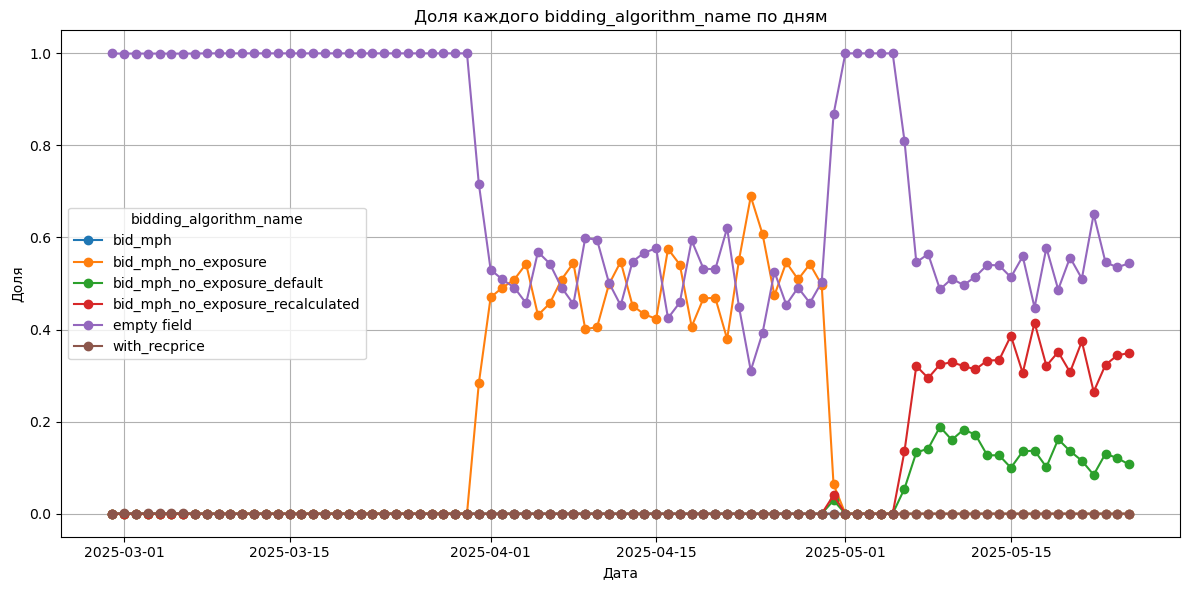

In [31]:
# Строим график
pivot.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Доля каждого bidding_algorithm_name по дням')
plt.ylabel('Доля')
plt.xlabel('Дата')
plt.grid(True)
plt.legend(title='bidding_algorithm_name')
plt.tight_layout()
plt.show()

df0

In [32]:
df0['bidding_algorithm_name'].unique()

array(['empty field', 'with_recprice', 'bid_mph'], dtype=object)

In [33]:
share_algo = share_bidding_algorithm(df0)
share_matches = share_bid_price_matches(df0, algo_names=['empty field'], len_max=3)
share_lengths = share_available_prices_length(df0, algo_names=['empty field'])
share_matches_by_len = share_bid_price_matches_by_len(df0, algo_names=['empty field'], len_max=3)

In [34]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df0['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'bid_mph': 0.0,
 'empty field': 0.9999,
 'with_recprice': 0.0001}
Максимальное кол-во шагов:
10
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.0,
 'len_10': 0.0,
 'len_2': 0.1084,
 'len_3': 0.8916,
 'len_4': 0.0,
 'len_5': 0.0,
 'len_6': 0.0,
 'len_7': 0.0,
 'len_8': 0.0,
 'len_9': 0.0,
 'total': 2379939}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': 0.0313,
                'share': 0.2691},
 'between_0_1': {'done_share': 0.1635,
                 'share': 0.0067},
 'between_1_2': {'done_share': 0.0922,
                 'share': 0.0299},
 'between_2_3': {'done_share': 0.0,
                 'share': 0.0},
 'match_first': {'done_share': 0.2446,
                 'share': 0.0946},
 'match_second': {'done_share': 0.1594,
                  'share': 0.2067},
 'match_sp': {'done_share': 0.4066,
              'share': 0.1782},
 'match_third': {'done_share': 0.0768,
                 'share': 0.207}}
Дол

In [35]:
print(
    len(df0[(df0['option_number'] == 'startprice') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 1') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 2') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 3') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    )

0.18594342123894772 0.09460998790305129 0.20673302971210605 0.20703976026276305


df1

In [36]:
df1['bidding_algorithm_name'].unique()

array(['empty field', 'bid_mph_no_exposure_recalculated',
       'bid_mph_no_exposure_default'], dtype=object)

In [37]:
share_algo = share_bidding_algorithm(df1)
share_matches = share_bid_price_matches(df1, algo_names=['empty field'], len_max=3)
share_lengths = share_available_prices_length(df1, algo_names=['empty field'])
share_matches_by_len = share_bid_price_matches_by_len(df1, algo_names=['empty field'], len_max=3)

In [38]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df1['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'bid_mph_no_exposure_default': 0.125,
 'bid_mph_no_exposure_recalculated': 0.3008,
 'empty field': 0.5742}
Максимальное кол-во шагов:
3
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.0,
 'len_2': 0.0965,
 'len_3': 0.9035,
 'total': 866329}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': 0.0338,
                'share': 0.2499},
 'between_0_1': {'done_share': 0.1523,
                 'share': 0.0075},
 'between_1_2': {'done_share': 0.0907,
                 'share': 0.031},
 'match_first': {'done_share': 0.2372,
                 'share': 0.1048},
 'match_second': {'done_share': 0.154,
                  'share': 0.2048},
 'match_sp': {'done_share': 0.3972,
              'share': 0.1925},
 'match_third': {'done_share': 0.0767,
                 'share': 0.2009}}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:
{'len_2': {'above_last': {'done_share': 0.0502,
          

In [39]:
share_algo = share_bidding_algorithm(df1)
share_matches = share_bid_price_matches(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                         'bid_mph_no_exposure_default'], len_max=3)
share_lengths = share_available_prices_length(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                               'bid_mph_no_exposure_default'])
share_matches_by_len = share_bid_price_matches_by_len(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                                       'bid_mph_no_exposure_default'], len_max=3)

In [40]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df1['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'bid_mph_no_exposure_default': 0.125,
 'bid_mph_no_exposure_recalculated': 0.3008,
 'empty field': 0.5742}
Максимальное кол-во шагов:
3
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.1732,
 'len_2': 0.4231,
 'len_3': 0.4037,
 'total': 642386}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': 0.0597,
                'share': 0.3772},
 'between_0_1': {'done_share': 0.1401,
                 'share': 0.0034},
 'between_1_2': {'done_share': 0.0908,
                 'share': 0.0115},
 'match_first': {'done_share': 0.2421,
                 'share': 0.1278},
 'match_second': {'done_share': 0.1611,
                  'share': 0.1756},
 'match_sp': {'done_share': 0.3913,
              'share': 0.1995},
 'match_third': {'done_share': 0.0682,
                 'share': 0.0959}}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:
{'len_1': {'above_last': {'done_share': 0.1075,
     

## !

In [41]:
columns = ['bid_uuid', 'etr', 'eta', 'price_highrate_value', 'price_start_value', 'bid_price_currency', 
           'steps_recalc_default', 'bidding_algorithm_name', 'available_prices_currency', 
           'steps_real_perc', 'max_bid']

t = 200
alpha = 0.1
steps_default_perc = [0.1, 0.2, 0.3]

In [42]:
def calculate_max_bid(row):
    t1 = row['etr']
    t2 = row['eta']
    rec_price = row['price_highrate_value']
    start_price = row['price_start_value']
    
    max_price = max(rec_price, start_price)
    time_diff_max = max(0, (t2 - t))
    
    # max_bid = (1+alpha) * max(Rec_price, Start_price) * (1 + (1+alpha) * max[0, (t2-t)]/(t1+t))
    max_bid = (1 + alpha) * max_price * (1 + time_diff_max / (t1 + t))

    if pd.isna(max_bid):
        return None
    else:
        return round(max_bid,4)

In [43]:
df_tmp = df1.sample(n=5).copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] != 'empty field'][columns].transpose()

""
bid_uuid
etr
eta
price_highrate_value
price_start_value
bid_price_currency
steps_recalc_default
bidding_algorithm_name
available_prices_currency
steps_real_perc


Случай, где max_bid больше третьей опции, но bid_mph_no_exposure_recalculated <br>

In [44]:
df_tmp = df1.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['case_check']].transpose()

,14,19,21,24,27,47,59,63,81,86,...,2905888,2905889,2905890,2905899,2905906,2905907,2905908,2905913,2905914,2905918
bid_uuid,0196c039-3e10-7602-85b0-82a52c7a1e7c,019701fb-b8ae-7103-bb87-6f53d857cedf,0196e3b6-63e4-7fac-b684-ee2a3e74ed2e,0196d023-bcbd-79bb-b974-4287b599eef4,0196b9ca-d188-76a4-a067-a2422b41d9cf,0196cb21-a9ef-760e-92d5-974265d44d9a,0196a9f3-76b8-747f-a5e5-001a0244eeb1,0196e8c7-f9f0-7aae-923c-339e7bd2753b,0196d93a-7ec1-75ee-8604-ae72a6e729f8,0196f00c-7535-755c-b5a4-bc9c1c34e5b5,...,0196ff00-c3a4-7925-92aa-2582cb89f518,0196ff03-cf56-7071-80d7-2aca7988a881,0196fda0-d10d-703c-b646-206780a6b135,0196ff00-d968-7925-98b1-530b149c4351,0196faef-fb76-7c02-8357-12f7bfdd7d0e,0196ff28-cef4-7952-8719-fe782c58a21f,0196fe9e-1f93-70f5-82ed-a0364e8b0b3b,0196fdf8-531e-70b3-9eb1-cf78b5632c15,0196fdf7-b6a3-70b3-9982-0bde91d78c6a,0196fdf7-9165-7ef2-8526-91adb2b38691
etr,801.0,975.0,987.0,1025.0,383.0,662.0,626.0,277.0,505.0,277.0,...,1801.0,1801.0,1533.0,1085.0,531.0,1614.0,1088.0,596.0,596.0,596.0
eta,360,240,300,60,300,360,480,300,840,180,...,600,300,180,180,180,600,360,420,180,180
price_highrate_value,10.0,10.0,10.0,8.0,7.0,8.0,6.0,5.0,5.0,5.0,...,11.0,11.0,12.0,10.0,10.0,10.0,11.0,10.0,10.0,10.0
price_start_value,10.0,10.0,10.0,10.0,7.0,8.0,5.0,6.0,7.0,6.0,...,12.0,12.0,10.0,12.0,10.0,10.0,10.0,10.0,10.0,10.0
bid_price_currency,10.0,10.0,10.0,12.0,9.0,8.0,10.0,6.0,10.0,6.0,...,17.0,12.0,17.0,15.0,10.0,12.0,20.0,15.0,14.0,14.0
steps_recalc_default,"[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[7.700000000000001, 8.4, 9.1]","[8.8, 9.6, 10.4]","[5.5, 6.0, 6.5]","[6.6000000000000005, 7.199999999999999, 7.8000...","[7.700000000000001, 8.4, 9.1]","[6.6000000000000005, 7.199999999999999, 7.8000...",...,"[13.200000000000001, 14.399999999999999, 15.60...","[13.200000000000001, 14.399999999999999, 15.60...","[11.0, 12.0, 13.0]","[13.200000000000001, 14.399999999999999, 15.60...","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,"[11.0, 12.0]","[11.0, 12.0]","[11.0, 12.0]","[11.0, 12.0]","[8.0, 9.0]","[9.0, 10.0]","[6.0, 7.0]",[6.0],"[8.0, 9.0]",[7.0],...,[14.0],[14.0],"[11.0, 12.0, 14.0]",[14.0],"[11.0, 12.0]","[11.0, 12.0]","[11.0, 12.0, 13.0]","[11.0, 12.0]","[11.0, 12.0]","[11.0, 12.0]"
steps_real_perc,"[1.1, 1.2]","[1.1, 1.2]","[1.1, 1.2]","[1.1, 1.2]","[1.1428571428571428, 1.2857142857142858]","[1.125, 1.25]","[1.2, 1.4]",[1.0],"[1.1428571428571428, 1.2857142857142858]",[1.1666666666666667],...,[1.1666666666666667],[1.1666666666666667],"[1.1, 1.2, 1.4]",[1.1666666666666667],"[1.1, 1.2]","[1.1, 1.2]","[1.1, 1.2, 1.3]","[1.1, 1.2]","[1.1, 1.2]","[1.1, 1.2]"


In [45]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.981403
                                  True          0.018597
bid_mph_no_exposure_recalculated  False         0.520777
                                  True          0.479223
empty field                       False         0.652042
                                  True          0.347958
dtype: float64

In [46]:
df_tmp[(df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated')
       & (df_tmp['case_check'] == False)].sample(n=5)[columns].transpose()

,2415476,968255,1545721,324761,2664532
bid_uuid,0196ddc8-3641-73fe-9f38-213ffa4dfded,0196cde6-56d0-710f-bd74-a8fb7ab285dc,0196e92b-6a4a-7a6a-940c-22a085609df5,0196bf9a-5619-7bf3-91ae-a34611dbc128,0196fd14-9d89-7507-a027-fd4757ec101a
etr,2436.0,811.0,1589.0,376.0,663.0
eta,540,240,540,600,780
price_highrate_value,21.0,8.0,11.0,11.0,6.0
price_start_value,20.0,7.0,11.0,11.0,6.0
bid_price_currency,34.0,7.0,15.0,11.0,6.0
steps_recalc_default,"[22.0, 24.0, 26.0]","[7.700000000000001, 8.4, 9.1]","[12.100000000000001, 13.2, 14.3]","[12.100000000000001, 13.2, 14.3]","[6.6000000000000005, 7.199999999999999, 7.8000..."
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,"[22.0, 24.0, 26.0]","[8.0, 9.0, 10.0]",[13.0],[13.0],[7.0]
steps_real_perc,"[1.1, 1.2, 1.3]","[1.1428571428571428, 1.2857142857142858, 1.428...",[1.1818181818181819],[1.1818181818181819],[1.1666666666666667]


In [47]:
df_tmp[(df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated')
       & (df_tmp['case_check'] == False)]['bid_uuid'].to_csv('recalculated_false_cases.csv', index=False)

Sabr MaxBid

In [48]:
def calculate_max_bid_Sabr(row):
    t1 = row['etr']
    t2 = max(row['eta'], t)
    rec_price = row['price_highrate_value']
    start_price = row['price_start_value']
    
    max_price = max(rec_price, start_price)
    time_diff_max = max(0, (t2 - t))
    
    max_bid = (1 + alpha) * max_price * (t1 + t2) / (t1 + t)

    if pd.isna(max_bid):
        return None
    else:
        return round(max_bid,4)

In [49]:
df_tmp = df1.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['max_bid_Sabr', 'case_check']].transpose()

,14,19,21,24,27,47,59,63,81,86,...,2905888,2905889,2905890,2905899,2905906,2905907,2905908,2905913,2905914,2905918
bid_uuid,0196c039-3e10-7602-85b0-82a52c7a1e7c,019701fb-b8ae-7103-bb87-6f53d857cedf,0196e3b6-63e4-7fac-b684-ee2a3e74ed2e,0196d023-bcbd-79bb-b974-4287b599eef4,0196b9ca-d188-76a4-a067-a2422b41d9cf,0196cb21-a9ef-760e-92d5-974265d44d9a,0196a9f3-76b8-747f-a5e5-001a0244eeb1,0196e8c7-f9f0-7aae-923c-339e7bd2753b,0196d93a-7ec1-75ee-8604-ae72a6e729f8,0196f00c-7535-755c-b5a4-bc9c1c34e5b5,...,0196ff00-c3a4-7925-92aa-2582cb89f518,0196ff03-cf56-7071-80d7-2aca7988a881,0196fda0-d10d-703c-b646-206780a6b135,0196ff00-d968-7925-98b1-530b149c4351,0196faef-fb76-7c02-8357-12f7bfdd7d0e,0196ff28-cef4-7952-8719-fe782c58a21f,0196fe9e-1f93-70f5-82ed-a0364e8b0b3b,0196fdf8-531e-70b3-9eb1-cf78b5632c15,0196fdf7-b6a3-70b3-9982-0bde91d78c6a,0196fdf7-9165-7ef2-8526-91adb2b38691
etr,801.0,975.0,987.0,1025.0,383.0,662.0,626.0,277.0,505.0,277.0,...,1801.0,1801.0,1533.0,1085.0,531.0,1614.0,1088.0,596.0,596.0,596.0
eta,360,240,300,60,300,360,480,300,840,180,...,600,300,180,180,180,600,360,420,180,180
price_highrate_value,10.0,10.0,10.0,8.0,7.0,8.0,6.0,5.0,5.0,5.0,...,11.0,11.0,12.0,10.0,10.0,10.0,11.0,10.0,10.0,10.0
price_start_value,10.0,10.0,10.0,10.0,7.0,8.0,5.0,6.0,7.0,6.0,...,12.0,12.0,10.0,12.0,10.0,10.0,10.0,10.0,10.0,10.0
bid_price_currency,10.0,10.0,10.0,12.0,9.0,8.0,10.0,6.0,10.0,6.0,...,17.0,12.0,17.0,15.0,10.0,12.0,20.0,15.0,14.0,14.0
steps_recalc_default,"[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[7.700000000000001, 8.4, 9.1]","[8.8, 9.6, 10.4]","[5.5, 6.0, 6.5]","[6.6000000000000005, 7.199999999999999, 7.8000...","[7.700000000000001, 8.4, 9.1]","[6.6000000000000005, 7.199999999999999, 7.8000...",...,"[13.200000000000001, 14.399999999999999, 15.60...","[13.200000000000001, 14.399999999999999, 15.60...","[11.0, 12.0, 13.0]","[13.200000000000001, 14.399999999999999, 15.60...","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,"[11.0, 12.0]","[11.0, 12.0]","[11.0, 12.0]","[11.0, 12.0]","[8.0, 9.0]","[9.0, 10.0]","[6.0, 7.0]",[6.0],"[8.0, 9.0]",[7.0],...,[14.0],[14.0],"[11.0, 12.0, 14.0]",[14.0],"[11.0, 12.0]","[11.0, 12.0]","[11.0, 12.0, 13.0]","[11.0, 12.0]","[11.0, 12.0]","[11.0, 12.0]"
steps_real_perc,"[1.1, 1.2]","[1.1, 1.2]","[1.1, 1.2]","[1.1, 1.2]","[1.1428571428571428, 1.2857142857142858]","[1.125, 1.25]","[1.2, 1.4]",[1.0],"[1.1428571428571428, 1.2857142857142858]",[1.1666666666666667],...,[1.1666666666666667],[1.1666666666666667],"[1.1, 1.2, 1.4]",[1.1666666666666667],"[1.1, 1.2]","[1.1, 1.2]","[1.1, 1.2, 1.3]","[1.1, 1.2]","[1.1, 1.2]","[1.1, 1.2]"


In [50]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.981403
                                  True          0.018597
bid_mph_no_exposure_recalculated  False         0.520777
                                  True          0.479223
empty field                       False         0.652042
                                  True          0.347958
dtype: float64

Before experiment

In [51]:
df_tmp = df0.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['max_bid_Sabr', 'case_check']].transpose()

""
bid_uuid
etr
eta
price_highrate_value
price_start_value
bid_price_currency
steps_recalc_default
bidding_algorithm_name
available_prices_currency
steps_real_perc


In [52]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name  case_check
bid_mph                 False         0.533333
                        True          0.466667
empty field             False         0.613072
                        True          0.386928
with_recprice           False         0.594684
                        True          0.405316
dtype: float64

Affected bids (not steps)

In [53]:
df_tmp = df0.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['bid_price_currency'], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'empty field'][columns + ['max_bid_Sabr', 'case_check']].transpose()

,0,9,12,20,22,23,26,28,29,30,...,4452915,4452917,4452918,4452919,4452922,4452923,4452924,4452927,4452929,4452930
bid_uuid,0195d48f-faba-7743-9fb3-bccf5a03518f,0195b09c-662f-74cc-b1ac-6ce1100931f3,01957d09-7b4a-700b-bddf-96271f15f49c,01958473-7136-72e6-8678-56c4e85e531c,0195597b-13a4-719d-8ae0-08eee5b6fd00,0195b1a5-99d2-7405-8e0a-b51c5bff793c,01956d1a-8fa4-7304-a8b0-b686245289e2,01957330-8928-7f26-a4a1-a1a1f4f36546,01956b7c-7dcd-790d-b4d0-c244c2d34643,01956c4c-9e98-779d-8dad-cfadd616bf22,...,01956860-cd32-7e3a-894d-733493ac4c3c,01959bcb-12fd-7112-bc54-138b999fc4f3,0195c7ac-e38e-72ad-902d-4123fb8086eb,0195cdd5-d9a7-73ee-9cd3-72c1af2eb0ae,01957709-efc0-72c0-a128-cb3e606a513a,0195c7cd-5ca2-7cfd-8ab5-e08b69ee0106,01957d8f-9914-7faf-bae5-2d9f6384cc87,0195ba36-3482-7a18-afde-71dd5bb5807c,0195a2ed-b85e-75e6-9400-95f24cc5c450,019572b0-575e-7de8-8ab4-89a6546ea793
etr,219.0,1051.0,648.0,1678.0,672.0,660.0,644.0,892.0,1887.0,425.0,...,948.0,625.0,405.0,1110.0,1087.0,334.0,492.0,548.0,1221.0,308.0
eta,480,360,60,240,720,180,300,480,240,300,...,300,427,180,286,360,120,420,300,360,480
price_highrate_value,6.0,10.0,NaN,12.0,12.0,8.0,6.0,9.0,14.0,5.0,...,9.0,7.0,9.0,10.0,10.0,9.0,10.0,7.0,12.0,7.0
price_start_value,5.0,10.0,9.0,12.0,10.0,12.0,5.0,10.0,14.0,6.0,...,10.0,15.0,5.0,10.0,9.0,5.0,10.0,7.0,20.0,5.0
bid_price_currency,5.0,12.0,10.0,18.0,12.0,14.0,6.0,13.0,14.0,7.0,...,14.0,15.0,7.0,12.0,9.0,7.0,10.0,9.0,25.0,7.0
steps_recalc_default,"[5.5, 6.0, 6.5]","[11.0, 12.0, 13.0]","[9.9, 10.799999999999999, 11.700000000000001]","[13.200000000000001, 14.399999999999999, 15.60...","[11.0, 12.0, 13.0]","[13.200000000000001, 14.399999999999999, 15.60...","[5.5, 6.0, 6.5]","[11.0, 12.0, 13.0]","[15.400000000000002, 16.8, 18.2]","[6.6000000000000005, 7.199999999999999, 7.8000...",...,"[11.0, 12.0, 13.0]","[16.5, 18.0, 19.5]","[5.5, 6.0, 6.5]","[11.0, 12.0, 13.0]","[9.9, 10.799999999999999, 11.700000000000001]","[5.5, 6.0, 6.5]","[11.0, 12.0, 13.0]","[7.700000000000001, 8.4, 9.1]","[22.0, 24.0, 26.0]","[5.5, 6.0, 6.5]"
bidding_algorithm_name,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,...,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field
available_prices_currency,"[6.0, 7.0]","[11.0, 12.0, 14.0]","[10.0, 11.0, 13.0]","[14.0, 15.0, 17.0]","[9.0, 10.0, 11.0]","[14.0, 15.0, 17.0]","[6.0, 7.0]","[11.0, 12.0, 14.0]","[16.0, 17.0, 19.0]","[6.0, 7.0]",...,"[11.0, 12.0, 14.0]","[17.0, 18.0, 21.0]","[6.0, 7.0]","[11.0, 12.0, 14.0]","[10.0, 11.0, 13.0]","[6.0, 7.0]","[11.0, 12.0, 14.0]","[8.0, 9.0, 10.0]","[22.0, 24.0, 27.0]","[6.0, 7.0]"
steps_real_perc,"[1.2, 1.4]","[1.1, 1.2, 1.4]","[1.1111111111111112, 1.2222222222222223, 1.444...","[1.1666666666666667, 1.25, 1.4166666666666667]","[0.9, 1.0, 1.1]","[1.1666666666666667, 1.25, 1.4166666666666667]","[1.2, 1.4]","[1.1, 1.2, 1.4]","[1.1428571428571428, 1.2142857142857142, 1.357...","[1.0, 1.1666666666666667]",...,"[1.1, 1.2, 1.4]","[1.1333333333333333, 1.2, 1.4]","[1.2, 1.4]","[1.1, 1.2, 1.4]","[1.1111111111111112, 1.2222222222222223, 1.444...","[1.2, 1.4]","[1.1, 1.2, 1.4]","[1.1428571428571428, 1.2857142857142858, 1.428...","[1.1, 1.2, 1.35]","[1.2, 1.4]"


In [54]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name  case_check
bid_mph                 False         0.466667
                        True          0.533333
empty field             False         0.619921
                        True          0.380079
with_recprice           False         0.571429
                        True          0.428571
dtype: float64

Choose Cities Query

In [55]:
def bids_data(start_date, stop_date, printBool=False):
    tmp_query = f"""
-- Замените 'YYYY-MM-DD' на ваши даты
-- DECLARE start_date DATE DEFAULT DATE('2023-01-01');
-- DECLARE stop_date DATE DEFAULT DATE('2023-01-02');

WITH
alpha_values AS (
    SELECT alpha_value
    FROM UNNEST([0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]) AS alpha_value
),

incity_details_raw AS (
    SELECT
        city_id,
        order_type,
        order_uuid,
        tender_uuid, -- Accepted bid's UUID for the order
        driveraccept_timestamp,
        driverarrived_timestamp,
        driverarrived_timestamp IS NOT NULL                                         AS is_order_arrived,
        driverdone_timestamp IS NOT NULL                                            AS is_order_done,
        price_start_usd AS start_price_incity_usd, -- Start_price from incity_detail
        duration_in_seconds AS t1_duration_seconds, -- This is t1
        ROW_NUMBER() OVER (
            PARTITION BY order_uuid 
            ORDER BY driveraccept_timestamp IS NULL, tender_timestamp ASC
        ) AS first_row_by_accepted_tender,
    FROM `indriver-e6e40.emart.incity_detail`
    WHERE TRUE
        AND created_date_order_part >= DATE_SUB(DATE('{start_date}'), INTERVAL 1 DAY)
        AND created_date_order_part <= DATE_ADD(DATE('{stop_date}'), INTERVAL 1 DAY)
        AND DATE(TIMESTAMP(FORMAT_TIMESTAMP('%Y-%m-%d %H:%M:%S', order_timestamp), timezone)) BETWEEN DATE('{start_date}') AND DATE('{stop_date}')
),

incity_details_base AS (
  SELECT *
  FROM incity_details_raw
  WHERE first_row_by_accepted_tender = 1
),

avg_rta_per_city_type AS (
    SELECT
        city_id,
        order_type,
        AVG(TIMESTAMP_DIFF(driverarrived_timestamp, driveraccept_timestamp, SECOND)) AS avg_rta_seconds_t -- This is 't'
    FROM incity_details_base
    WHERE is_order_arrived = TRUE
    GROUP BY city_id, order_type
),

order_global_info AS (
    SELECT
        uuid AS order_uuid,
        MAX(multiplier) AS multiplier,
        MAX(price_highrate_value / COALESCE(multiplier, 100)) AS price_highrate_value,
        MAX(payment_price_value / COALESCE(multiplier, 100)) AS price_start_value
    FROM `indriver-e6e40.ods_new_order_rh_cdc.order_global_strm`
    WHERE uuid IN (SELECT DISTINCT order_uuid FROM incity_details_base)
      AND DATE(created_at) >= DATE('{start_date}') 
      AND DATE(created_at) <= DATE('{stop_date}')
    GROUP BY uuid
),

bids_raw AS (
    SELECT
        uuid AS bid_uuid,
        order_uuid,
        price AS bid_price_value,
        SAFE_CAST(SUBSTR(eta, 1, STRPOS(eta, 's') - 1) AS INT64) AS t2_eta_seconds, -- This is 't2'
        created_at AS utc_bid_dttm
    FROM `indriver-e6e40.ods_new_order_rh_cdc.bid_global_strm`
    WHERE status = 'BID_STATUS_ACTIVE'
      AND order_uuid IN (SELECT DISTINCT order_uuid FROM incity_details_base)
      AND DATE(created_at) BETWEEN DATE('{start_date}') AND DATE('{stop_date}')
),

bids_enriched AS (
    SELECT
        b_raw.bid_uuid,
        b_raw.order_uuid,
        b_raw.utc_bid_dttm,
        b_raw.t2_eta_seconds,
        idb.city_id,
        idb.order_type,
        idb.tender_uuid AS order_accepted_tender_uuid,
        idb.is_order_done,
        idb.t1_duration_seconds,
        ogi.price_highrate_value,
        ogi.price_start_value,
        idb.start_price_incity_usd, -- Start_price (from incity_detail, for reference or alternative)
        b_raw.bid_price_value / COALESCE(ogi.multiplier, 100) AS bid_price_value,
        art.avg_rta_seconds_t
    FROM bids_raw b_raw
    LEFT JOIN incity_details_base idb ON b_raw.order_uuid = idb.order_uuid
    LEFT JOIN order_global_info ogi ON b_raw.order_uuid = ogi.order_uuid
    LEFT JOIN avg_rta_per_city_type art ON idb.city_id = art.city_id AND idb.order_type = art.order_type
),

-- Evaluate bids based on the formula
evaluated_bids AS (
    SELECT
        be.*,
        av.alpha_value,
        -- max_permissible_bid formula: (1+alpha) * max(Rec_price, Start_price) * (1 + max(0, (t2-t))/(t1+t))
        ( (1 + av.alpha_value) * GREATEST(COALESCE(be.price_highrate_value, 0), COALESCE(be.price_start_value, 0)) * -- Using COALESCE for safety, though filters should handle NULLs
            (1 + GREATEST(0, COALESCE(be.t2_eta_seconds, 0) - COALESCE(be.avg_rta_seconds_t, 0)) /
                 NULLIF( (COALESCE(be.t1_duration_seconds, 0) + COALESCE(be.avg_rta_seconds_t, 0)) , 0)
            )
        ) AS max_permissible_bid
    FROM bids_enriched be
    CROSS JOIN alpha_values av
    WHERE be.price_highrate_value IS NOT NULL      
      AND be.price_start_value IS NOT NULL 
      AND be.t1_duration_seconds IS NOT NULL 
      -- avg_rta_seconds_t (t) can be null (coalesced to 0 in formula)
      -- t2_eta_seconds (t2) can be null (coalesced to 0 in formula)
),

bids_with_bad_status AS (
    SELECT
        *,
        (max_permissible_bid IS NOT NULL AND bid_price_value > max_permissible_bid) AS is_bad_bid
    FROM evaluated_bids
),

-- Metric 1: Доля плохих бидов
overall_bad_bid_share AS (
    SELECT
        city_id,
        order_type,
        avg_rta_seconds_t,
        alpha_value,
        COUNTIF(max_permissible_bid IS NOT NULL) AS total_bids_rule_applicable,
        SUM(CAST(is_bad_bid AS INT64)) AS count_bad_bids,
        SAFE_DIVIDE(SUM(CAST(is_bad_bid AS INT64)), COUNTIF(max_permissible_bid IS NOT NULL)) AS share_of_bad_bids
    FROM bids_with_bad_status
    GROUP BY city_id, order_type, avg_rta_seconds_t, alpha_value
),

-- Metric 2: Доля завершенных заказов с плохим принятым бидом
-- First, identify completed orders and if their accepted tender was bad
accepted_tender_evaluation AS (
    SELECT
        bws.order_uuid,
        bws.city_id,
        bws.order_type,
        bws.alpha_value,
        bws.is_order_done,
        bws.is_bad_bid AS is_accepted_tender_bad,
        (bws.max_permissible_bid IS NOT NULL) AS is_accepted_tender_rule_applicable
    FROM bids_with_bad_status bws
    WHERE bws.bid_uuid = bws.order_accepted_tender_uuid -- Focus on the accepted bid
      AND bws.is_order_done = TRUE -- Only completed orders
),

-- Count completed orders where the accepted tender was bad (and rule was applicable)
done_orders_with_bad_tender_counts AS (
    SELECT
        city_id,
        order_type,
        alpha_value,
        COUNTIF(is_accepted_tender_bad = TRUE AND is_accepted_tender_rule_applicable = TRUE) AS num_done_orders_with_bad_tender
    FROM accepted_tender_evaluation
    GROUP BY city_id, order_type, alpha_value
),

-- Denominator for Metric 2: Total completed orders for each city/type
all_completed_orders_count AS (
    SELECT
        city_id,
        order_type,
        COUNT(DISTINCT order_uuid) AS count_all_completed_orders
    FROM incity_details_base -- Filtered by date range
    WHERE is_order_done = TRUE
    GROUP BY city_id, order_type
),

-- Calculate final Metric 2
final_metric_done_orders_bad_tender AS (
    SELECT
        acoc.city_id,
        acoc.order_type,
        av.alpha_value, -- Ensure all alphas are present for each city/type
        acoc.count_all_completed_orders,
        COALESCE(dowbtc.num_done_orders_with_bad_tender, 0) AS num_done_orders_with_bad_tender,
        SAFE_DIVIDE(
            COALESCE(dowbtc.num_done_orders_with_bad_tender, 0),
            acoc.count_all_completed_orders
        ) AS share_done_orders_with_bad_tender -- Denominator is ALL completed orders
    FROM all_completed_orders_count acoc
    CROSS JOIN alpha_values av -- Ensures all alphas are present for every city/type
    LEFT JOIN done_orders_with_bad_tender_counts dowbtc
        ON acoc.city_id = dowbtc.city_id
        AND acoc.order_type = dowbtc.order_type
        AND av.alpha_value = dowbtc.alpha_value
)

-- Combine all metrics for the final output
SELECT
    COALESCE(m1.city_id, m2.city_id)            AS city_id,
    COALESCE(m1.order_type, m2.order_type)      AS order_type,
    m1.avg_rta_seconds_t                        AS avg_rta,
    COALESCE(m1.alpha_value, m2.alpha_value)    AS alpha_value,
    m1.total_bids_rule_applicable               AS bids_count,               
    m1.count_bad_bids                           AS bad_bids_count,
    m1.share_of_bad_bids                        AS bad_bids_share,
    m2.count_all_completed_orders               AS rides_count,
    m2.num_done_orders_with_bad_tender          AS rides_badbids_count,
    m2.share_done_orders_with_bad_tender        AS rides_badbids_share
FROM overall_bad_bid_share m1
FULL JOIN final_metric_done_orders_bad_tender m2
    ON m1.city_id = m2.city_id
    AND m1.order_type = m2.order_type
    AND m1.alpha_value = m2.alpha_value
ORDER BY
    city_id,
    order_type,
    alpha_value;
    """
    
    if printBool:
        print(tmp_query)
    # query = f"""
    # SELECT *
    # FROM `analytics-dev-333113.temp.df_tender_{user_name}_exp`
    # """

    return client.query(tmp_query).result().to_dataframe()

In [56]:
from google.cloud import bigquery
client = bigquery.Client(project='analytics-dev-333113')

start_date = '2025-05-01'
end_date = '2025-05-19'

df0_choosecities = bids_data(start_date=start_date, stop_date=end_date, printBool = True)
df0_choosecities.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_df0_choosecities.csv', index=False)

# city_id=CITY_ID, order_type=ORDER_TYPE


-- Замените 'YYYY-MM-DD' на ваши даты
-- DECLARE start_date DATE DEFAULT DATE('2023-01-01');
-- DECLARE stop_date DATE DEFAULT DATE('2023-01-02');

WITH
alpha_values AS (
    SELECT alpha_value
    FROM UNNEST([0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]) AS alpha_value
),

incity_details_raw AS (
    SELECT
        city_id,
        order_type,
        order_uuid,
        tender_uuid, -- Accepted bid's UUID for the order
        driveraccept_timestamp,
        driverarrived_timestamp,
        driverarrived_timestamp IS NOT NULL                                         AS is_order_arrived,
        driverdone_timestamp IS NOT NULL                                            AS is_order_done,
        price_start_usd AS start_price_incity_usd, -- Start_price from incity_detail
        duration_in_seconds AS t1_duration_seconds, -- This is t1
        ROW_NUMBER() OVER (
            PARTITION BY order_uuid 
            ORDER BY driveraccept_timestamp IS NULL, tender_timestamp ASC
        ) A

In [57]:
df0_choosecities[(df0_choosecities['city_id'] == CITY_ID) & 
                 (df0_choosecities['order_type'] == ORDER_TYPE)]

,city_id,order_type,avg_rta,alpha_value,bids_count,bad_bids_count,bad_bids_share,rides_count,rides_badbids_count,rides_badbids_share
4952,4373,moto_econom,343.801055,0.100,1371469,611394,0.445795,234356,64444,0.274983
4953,4373,moto_econom,343.801055,0.125,1371469,557540,0.406528,234356,56409,0.240698
4954,4373,moto_econom,343.801055,0.150,1371469,512115,0.373406,234356,50109,0.213816
4955,4373,moto_econom,343.801055,0.200,1371469,407115,0.296846,234356,34588,0.147587
4956,4373,moto_econom,343.801055,0.250,1371469,320653,0.233803,234356,24002,0.102417
4957,4373,moto_econom,343.801055,0.300,1371469,274490,0.200143,234356,20359,0.086872
4958,4373,moto_econom,343.801055,0.350,1371469,223288,0.162809,234356,15891,0.067807
4959,4373,moto_econom,343.801055,0.400,1371469,164774,0.120144,234356,9880,0.042158


OG bid approach

In [58]:
from google.cloud import bigquery
client = bigquery.Client(project='analytics-dev-333113')

def download_og_bid_data(start_date, stop_date, city_id, order_type, printBool=False):
    tmp_query = f"""
    WITH
    timezone_data AS (SELECT city_id,
                             timezone
                      FROM `indriver-e6e40.emart.incity_detail`
                      WHERE true
                        AND city_id = {city_id}
                        AND created_date_order_part = CURRENT_DATE()
                      LIMIT 1),

    rider_data AS (SELECT t1.city_id                  AS city_id,
                          uuid                        AS order_uuid,
                          payment_price_value         AS price,
                          modified_at                 AS modified_at_utc,
                          'rider_price'               AS price_type,
                          price_highrate_value        AS price_highrate_value,
                          CAST(NULL AS INT64)         AS order_rn,
                          CAST(NULL AS INT64)         AS tender_rn,
                          CAST(NULL AS STRING)        AS tender_uuid,
                          CAST(NULL AS ARRAY <INT64>) AS available_prices,
                          CAST(NULL AS INT64)         AS contractor_id,
                          CAST(NULL AS INT64)         AS eta,
                          duration_in_seconds         AS duration_in_seconds,
                          CAST(NULL AS STRING)        AS accepted_status,
                          type_name                   AS order_type,
                          CAST(NULL AS STRING)        AS bidding_algorithm_name
                   FROM `indriver-e6e40.ods_new_order_rh_cdc.order_global_strm` t1
                        LEFT JOIN timezone_data tz
                            ON t1.city_id = tz.city_id
                        LEFT JOIN (SELECT order_uuid,
                                          duration_in_seconds,
                                   FROM `indriver-e6e40.emart.incity_detail`
                                   WHERE true
                                     AND city_id = {city_id}
                                     AND created_date_order_part BETWEEN '{start_date}' AND '{stop_date}') t2
                            ON t1.uuid = t2.order_uuid  
                   WHERE true
                     AND TIMESTAMP_TRUNC(created_at, DAY) BETWEEN
                       TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}')), INTERVAL -1 DAY)
                       AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}')), INTERVAL 2 DAY)
                     AND created_at BETWEEN
                       TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}'), tz.timezone), INTERVAL 0 DAY)
                       AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}'), tz.timezone), INTERVAL 1
                                         DAY)
                     AND t1.city_id = {city_id}
                     AND type_name = '{order_type}'
                   QUALIFY ROW_NUMBER() OVER (PARTITION BY uuid, payment_price_value ORDER BY modified_at) = 1),

    accepted_bids AS (SELECT distinct
                             order_uuid AS order_uuid,
                             uuid       AS tender_uuid,
                             status     AS accepted_status,
                      FROM `indriver-e6e40.ods_new_order_rh_cdc.bid_global_strm`
                      WHERE true
                        AND TIMESTAMP_TRUNC(created_at, DAY) BETWEEN
                          TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}')), INTERVAL -1 DAY)
                          AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}')), INTERVAL 2 DAY)
                        AND status = 'BID_STATUS_ACCEPTED'
                        AND order_uuid IN (SELECT order_uuid FROM rider_data)),
                        
    bid_data AS (SELECT distinct
                        CAST((ARRAY(SELECT DISTINCT city_id FROM rider_data LIMIT 1))[OFFSET(0)] AS INT64) AS city_id,
                        t.order_uuid                                                                       AS order_uuid,
                        price                                                                              AS price,
                        modified_at                                                                        AS modified_at_utc,
                        'bid_price'                                                                        AS price_type,
                        CAST(NULL AS INT64)                                                                AS price_highrate_value,
                        DENSE_RANK() OVER (ORDER BY t.order_uuid)                                          AS order_rn,
                        ROW_NUMBER() OVER (PARTITION BY t.order_uuid ORDER BY modified_at)                 AS tender_rn,
                        uuid                                                                               AS tender_uuid,
                        available_prices                                                                   AS available_prices,
                        contractor_id                                                                      AS contractor_id,
                        SAFE_CAST(SUBSTR(eta, 1, STRPOS(eta, 's') - 1) AS INT64)                           AS eta,
                        CAST(NULL AS INT64)                                                                AS duration_in_seconds,
                        accepted_status                                                                    AS accepted_status,
                        CAST(NULL AS STRING)                                                               AS order_type,
                        bidding_algorithm_name                                                             AS bidding_algorithm_name
                 FROM `indriver-e6e40.ods_new_order_rh_cdc.bid_global_strm` t
                 LEFT JOIN accepted_bids
                    ON t.order_uuid = accepted_bids.order_uuid
                        AND t.uuid = accepted_bids.tender_uuid
                 WHERE true
                   AND TIMESTAMP_TRUNC(created_at, DAY) BETWEEN
                     TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}')), INTERVAL -1 DAY)
                     AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}')), INTERVAL 2 DAY)
                   AND status = 'BID_STATUS_ACTIVE'
                   AND t.order_uuid IN (SELECT order_uuid FROM rider_data)),

    your_table AS (SELECT *
                   FROM (SELECT *
                         FROM rider_data
                         UNION ALL
                         SELECT *
                         FROM bid_data)
                   ORDER BY order_uuid, modified_at_utc),

    pass_groups AS (SELECT order_uuid,
                           price,
                           modified_at_utc,
                           price_type,
                           SUM(CASE WHEN price_type = 'rider_price' THEN 1 ELSE 0 END)
                               OVER (PARTITION BY order_uuid ORDER BY modified_at_utc) AS pass_group,
                           price_highrate_value,
                           available_prices,
                           contractor_id,
                           tender_uuid,
                           city_id,
                           eta,
                           duration_in_seconds,
                           accepted_status,
                           bidding_algorithm_name
                    FROM your_table),

    full_data_table AS (SELECT city_id,
                               order_uuid,
                               price,
                               price_type,
                               modified_at_utc,
                               available_prices,
                               LAST_VALUE(CASE WHEN price_type = 'rider_price' THEN price END IGNORE NULLS)
                                          OVER (PARTITION BY order_uuid, pass_group ORDER BY modified_at_utc ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
                                   AS last_pass_price,
                               LAST_VALUE(CASE WHEN price_type = 'rider_price' THEN price_highrate_value END IGNORE NULLS)
                                          OVER (PARTITION BY order_uuid ORDER BY modified_at_utc ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
                                   AS price_highrate_value,
                               contractor_id,
                               tender_uuid,
                               eta, 
                               LAST_VALUE(CASE WHEN price_type = 'rider_price' THEN duration_in_seconds END IGNORE NULLS)
                                          OVER (PARTITION BY order_uuid ORDER BY modified_at_utc ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
                                   AS duration_in_seconds,
                               accepted_status,
                               bidding_algorithm_name
                        FROM pass_groups),

    options_assign AS (SELECT *,
                              CASE
                                  WHEN price_type = 'rider_price' THEN NULL
                                  ELSE
                                      COALESCE(
                                              (SELECT CASE
                                                          WHEN price = last_pass_price
                                                              THEN 'startprice'
                                                          WHEN price = available_prices[offset]
                                                              THEN 'option ' || CAST(offset + 1 AS STRING)
                                                          WHEN price < available_prices[SAFE_OFFSET(0)]
                                                              THEN 'option 1-'
                                                          WHEN price >
                                                               available_prices[SAFE_OFFSET(ARRAY_LENGTH(available_prices) - 1)]
                                                              THEN 'option ' || CAST(ARRAY_LENGTH(available_prices) AS STRING) || '+'
                                                          ELSE 'option ' || CAST(offset + 1 AS STRING) ||
                                                               (CASE WHEN price > available_prices[offset] THEN '+' ELSE '-' END)
                                                          END
                                               FROM UNNEST(available_prices) WITH OFFSET AS offset
                                               WHERE price = available_prices[offset]
                                                  OR (price < available_prices[offset] AND
                                                      (offset = 0 OR price > available_prices[offset - 1]))
                                                  OR (price > available_prices[offset] AND
                                                      (offset = ARRAY_LENGTH(available_prices) - 1 OR
                                                       price < available_prices[offset + 1]))
                                               LIMIT 1),
                                              'other'
                                      ) END AS option_number
                       FROM full_data_table),

    result AS (SELECT *,
               FROM options_assign AS t
                        LEFT JOIN timezone_data tz
                                  ON t.city_id = tz.city_id
               WHERE price_type = 'bid_price')

    SELECT *
    FROM result
    WHERE DATETIME_TRUNC(modified_at_utc, DAY) BETWEEN
      TIMESTAMP(DATETIME_TRUNC(PARSE_DATETIME('%Y-%m-%d', '{start_date}'), DAY))
      AND TIMESTAMP(DATETIME_TRUNC(PARSE_DATETIME('%Y-%m-%d', '{stop_date}'), DAY))
    ORDER BY modified_at_utc
    """

    if printBool:
        print(tmp_query)
    
    return client.query(tmp_query).result().to_dataframe()

In [59]:
start_date = '2025-05-20'
end_date = '2025-06-20'

df1_og = download_og_bid_data(start_date=start_date, stop_date=end_date, city_id=CITY_ID, order_type=ORDER_TYPE, printBool = True)
df1_og.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_df1_og.csv', index=False)


    WITH
    timezone_data AS (SELECT city_id,
                             timezone
                      FROM `indriver-e6e40.emart.incity_detail`
                      WHERE true
                        AND city_id = 4373
                        AND created_date_order_part = CURRENT_DATE()
                      LIMIT 1),

    rider_data AS (SELECT t1.city_id                  AS city_id,
                          uuid                        AS order_uuid,
                          payment_price_value         AS price,
                          modified_at                 AS modified_at_utc,
                          'rider_price'               AS price_type,
                          price_highrate_value        AS price_highrate_value,
                          CAST(NULL AS INT64)         AS order_rn,
                          CAST(NULL AS INT64)         AS tender_rn,
                          CAST(NULL AS STRING)        AS tender_uuid,
                          CAST(NULL AS ARRAY <

In [60]:
column_mapping = {
    'last_pass_price': 'price_start_value',
    'available_prices': 'available_prices_currency',
    'duration_in_seconds': 'etr',
    'price': 'bid_price_currency',
    'tender_uuid': 'bid_uuid'
}

df1_og = df1_og.rename(columns=column_mapping)
df1_og['bidding_algorithm_name'] = df1_og['bidding_algorithm_name'].replace('', 'empty field')

In [61]:
def calculate_max_bid_Sabr(row):
    t1 = row['etr']
    t2 = row['eta']
    rec_price = row['price_highrate_value']
    start_price = row['price_start_value']
    
    max_price = max(rec_price, start_price)
    time_diff_max = max(0, (t2 - t))
    
    max_bid = (1 + alpha) * max_price * (t1 + t2) / (t1 + t)

    return max_bid

In [62]:
df_tmp = df1_og.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['option_number', 'max_bid_Sabr', 'case_check']].transpose()

,165,166,167,168,171,172,173,174,175,176,...,423194,423195,423196,423197,423198,423199,423200,423201,423202,423203
bid_uuid,0196ebb0-1586-7b1e-aded-930ac2393730,0196ebb0-1699-7b1e-94ef-8d7b3fe25018,0196ebb0-1ae7-7b1e-bff6-09dfbbd7b720,0196ebb0-1cc6-7b1e-bd85-c09465fb8dda,0196ebb0-37ff-7b1f-a0ed-4e7ca62af011,0196ebb0-393d-7b1f-8463-4e8465069a6a,0196ebb0-6fc5-7fed-b1c7-16288ba0b83d,0196ebb0-777d-7fed-9ba5-783d2ea663a3,0196ebb0-7b41-7fed-b951-ebdd32dc5ad6,0196ebb0-80e8-7fed-9841-f5af771885c9,...,01970bc3-b06e-7b8d-86ab-b41da38d3b16,01970bc3-b0df-791f-bae0-e28e5a38a30b,01970bc3-b180-791f-a4b2-8bfd827814ec,01970bc3-c21e-791f-9838-37949865b2e6,01970bc3-da75-7b8e-8076-9b202dfaccbc,01970bc3-dd79-7920-808a-007645873c68,01970bc4-22c8-7921-adea-24d5797504a5,01970bc4-2708-7921-a7e3-f45f009097a1,01970bc4-2da8-7921-a4f5-540235f43a19,01970bc4-3824-7921-82cc-6e740184d28f
etr,513,817,1420,660,1489,478,270,442,1620,817,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
eta,60,180,420,300,240,480,240,420,300,180,...,300,240,360,360,660,600,540,360,180,600
price_highrate_value,500.0,900.0,1100.0,700.0,1800.0,600.0,500.0,800.0,2000.0,900.0,...,500.0,1800.0,900.0,1400.0,1500.0,2000.0,500.0,700.0,500.0,2000.0
price_start_value,800,1250,1100,2800,1800,500,800,800,2000,1250,...,500,1500,900,1600,1500,2000,800,700,800,2000
bid_price_currency,1000,1500,1500,2800,2800,1000,800,1000,2700,1500,...,600,1800,900,1700,2300,4000,1000,1000,1000,4000
steps_recalc_default,"[880.0000000000001, 960.0, 1040.0]","[1375.0, 1500.0, 1625.0]","[1210.0, 1320.0, 1430.0]","[3080.0000000000005, 3360.0, 3640.0]","[1980.0000000000002, 2160.0, 2340.0]","[550.0, 600.0, 650.0]","[880.0000000000001, 960.0, 1040.0]","[880.0000000000001, 960.0, 1040.0]","[2200.0, 2400.0, 2600.0]","[1375.0, 1500.0, 1625.0]",...,"[550.0, 600.0, 650.0]","[1650.0000000000002, 1800.0, 1950.0]","[990.0000000000001, 1080.0, 1170.0]","[1760.0000000000002, 1920.0, 2080.0]","[1650.0000000000002, 1800.0, 1950.0]","[2200.0, 2400.0, 2600.0]","[880.0000000000001, 960.0, 1040.0]","[770.0000000000001, 840.0, 910.0]","[880.0000000000001, 960.0, 1040.0]","[2200.0, 2400.0, 2600.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,"[900, 1000]","[1400, 1500]",[1300],"[3100, 3300]","[2000, 2100]","[600, 700]","[900, 1000]","[900, 1000]","[2200, 2300]","[1400, 1500]",...,[600],"[1700, 1800, 2100]","[1000, 1100]","[1800, 1900]","[1700, 1800]","[2200, 2300]","[900, 1000]","[800, 900]","[900, 1000]","[2200, 2300]"
steps_real_perc,"[1.125, 1.25]","[1.12, 1.2]",[1.1818181818181819],"[1.1071428571428572, 1.1785714285714286]","[1.1111111111111112, 1.1666666666666667]","[1.2, 1.4]","[1.125, 1.25]","[1.125, 1.25]","[1.1, 1.15]","[1.12, 1.2]",...,[1.2],"[1.1333333333333333, 1.2, 1.4]","[1.1111111111111112, 1.2222222222222223]","[1.125, 1.1875]","[1.1333333333333333, 1.2]","[1.1, 1.15]","[1.125, 1.25]","[1.1428571428571428, 1.2857142857142858]","[1.125, 1.25]","[1.1, 1.15]"


In [63]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.987768
                                  True          0.012232
bid_mph_no_exposure_recalculated  False         0.517400
                                  True          0.482600
empty field                       False         0.643793
                                  True          0.356207
dtype: float64

Случай, где шаги бидов ниже старта: <br> bid_uuid == '0196f598-c67d-73b5-beb8-3bca5f30bc71'

In [64]:
df_tmp = df1.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)
df_tmp['case_check'] = df_tmp.apply(lambda x: x['available_prices_currency'][0] / x['price_start_value'] < 1.1, axis=1)

columns += ['case_check']
df_tmp[df_tmp['bidding_algorithm_name'] == 'empty field'][columns].transpose()

,7,11,13,15,16,20,22,31,33,40,...,2905898,2905911,2905912,2905915,2905916,2905917,2905920,2905922,2905923,2905924
bid_uuid,0196e84f-6cd8-7f13-950c-cb751f4477bc,01969de7-66a8-70a1-a7a4-9436cd6533fc,0196a2e2-5f9a-7a84-a810-e3bb6a83bda1,0196c0bc-97b9-7661-8021-e51030dcf2a7,0196dc47-17af-72d3-9b48-dde602996616,0197008a-8a94-7b50-a197-a5f2038f39c8,0196c223-8a07-7e68-95b3-971126d54365,0196b58d-6ead-77c8-86d5-0585b911735e,0196a31c-deb9-7b11-856a-a92deb3cc550,0196d897-a057-7e80-b377-3dc0c2779a1d,...,0196fe0c-8a8b-70d1-8d4b-c6439c080c5b,0197024d-335d-7d56-a7ab-f1ad2d4297e7,019704b2-1f82-7751-a36c-b6c2ed098f18,0196ffdd-fda6-7186-9653-97f2f7d8ff47,0197035e-ef89-707b-b260-bf1dc5a65de3,0197031e-a53f-7573-8fe7-de98f6e3d62c,0196fead-d316-7007-9164-56cf774d229b,01970281-a652-7480-8139-6e64bfc6826d,01970281-9ade-7dac-8683-15dca45929e2,0197027f-d2b4-71db-9ed4-da5c563ec191
etr,153.0,854.0,995.0,2059.0,848.0,204.0,749.0,1859.0,876.0,1803.0,...,843.0,1976.0,1119.0,939.0,1059.0,869.0,1323.0,1097.0,1097.0,1097.0
eta,180,480,660,5040,720,300,60,60,420,360,...,420,780,360,540,300,480,240,540,420,840
price_highrate_value,5.0,11.0,16.0,22.0,13.0,7.0,12.0,13.0,14.0,18.0,...,8.0,13.0,10.0,14.0,13.0,12.0,10.0,11.0,11.0,11.0
price_start_value,5.0,9.0,8.0,20.0,14.0,7.0,13.5,13.0,12.0,10.0,...,10.0,16.0,10.0,14.0,10.0,10.0,10.0,11.0,11.0,11.0
bid_price_currency,10.0,13.0,14.0,20.0,14.0,7.0,15.0,15.0,18.0,15.0,...,10.0,22.0,10.0,19.0,15.0,12.0,14.0,11.0,12.0,15.0
steps_recalc_default,"[5.5, 6.0, 6.5]","[9.9, 10.799999999999999, 11.700000000000001]","[8.8, 9.6, 10.4]","[22.0, 24.0, 26.0]","[15.400000000000002, 16.8, 18.2]","[7.700000000000001, 8.4, 9.1]","[14.850000000000001, 16.2, 17.55]","[14.3, 15.6, 16.900000000000002]","[13.200000000000001, 14.399999999999999, 15.60...","[11.0, 12.0, 13.0]",...,"[11.0, 12.0, 13.0]","[17.6, 19.2, 20.8]","[11.0, 12.0, 13.0]","[15.400000000000002, 16.8, 18.2]","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[11.0, 12.0, 13.0]","[12.100000000000001, 13.2, 14.3]","[12.100000000000001, 13.2, 14.3]","[12.100000000000001, 13.2, 14.3]"
bidding_algorithm_name,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,...,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field
available_prices_currency,"[6.0, 7.0]","[10.0, 11.0, 13.0]","[9.0, 10.0, 11.0]","[21.0, 23.0, 26.0]","[16.0, 17.0, 19.0]","[8.0, 9.0, 10.0]","[14.0, 15.0, 17.0]","[15.0, 16.0, 18.0]","[11.0, 12.0, 14.0]","[11.0, 12.0, 14.0]",...,"[11.0, 12.0, 14.0]","[17.0, 18.0, 21.0]","[11.0, 12.0, 14.0]","[16.0, 17.0, 19.0]","[11.0, 12.0, 14.0]","[11.0, 12.0, 14.0]","[11.0, 12.0, 14.0]","[13.0, 14.0, 15.0]","[13.0, 14.0, 15.0]","[11.0, 12.0, 14.0]"
steps_real_perc,"[1.2, 1.4]","[1.1111111111111112, 1.2222222222222223, 1.444...","[1.125, 1.25, 1.375]","[1.05, 1.15, 1.3]","[1.1428571428571428, 1.2142857142857142, 1.357...","[1.1428571428571428, 1.2857142857142858, 1.428...","[1.037037037037037, 1.1111111111111112, 1.2592...","[1.1538461538461537, 1.2307692307692308, 1.384...","[0.9166666666666666, 1.0, 1.1666666666666667]","[1.1, 1.2, 1.4]",...,"[1.1, 1.2, 1.4]","[1.0625, 1.125, 1.3125]","[1.1, 1.2, 1.4]","[1.1428571428571428, 1.2142857142857142, 1.357...","[1.1, 1.2, 1.4]","[1.1, 1.2, 1.4]","[1.1, 1.2, 1.4]","[1.1818181818181819, 1.2727272727272727, 1.363...","[1.1818181818181819, 1.2727272727272727, 1.363...","[1.0, 1.0909090909090908, 1.2727272727272727]"


In [65]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.860629
                                  True          0.139371
bid_mph_no_exposure_recalculated  False         0.899907
                                  True          0.100093
empty field                       False         0.884168
                                  True          0.115832
dtype: float64